## Введение

Нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

    Закон смещения Вина.    
    Закон Стефана-Больцмана.
    Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Алгоритм работы:
- ознакомиться с данными
- выполнить предобработку данных
- сделать модель baseline
- сделать барплот с истинной температурой/прогноз
- улучшить модель с помощью регулиризации и обучению по батчам
- получить RMSE не ниже 4500


## Обзор данных

Загрузим библиотеки и посмотрим данные

In [26]:
import urllib.request
import pandas as pd


from os import path
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterSampler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
import random
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_name = '6_class.csv'
#download dataset if not existed
if not path.exists(dataset_folder + '/' + dataset_name):
    #create dir if not existed
    Path(dataset_folder).mkdir(parents=True, exist_ok=True)

    #download dataset
    urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                               dataset_folder+'/'+ dataset_name)

df = pd.read_csv(dataset_folder +'/'+ dataset_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [27]:
df = pd.read_csv(dataset_folder +'/'+ dataset_name)

In [28]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [29]:
df.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

переименуем колонки

In [30]:
df.rename(columns={"Unnamed: 0": "id",
                   "Temperature (K)": "temperature",
                   "Luminosity(L/Lo)": "luminocity",
                   "Radius(R/Ro)": "radius",
                   "Absolute magnitude(Mv)": "absolute_magnitude",
                   "Star type": "star_type",
                   "Star color": "star_color"
                    }, inplace=True)

удалим id

In [31]:
X = df.drop(["id", "temperature"], axis=1)
y = df["temperature"]

## Исследование и предобработка данных

посмотрим корреляцию таргета с признаками

In [32]:
t = df.drop(["id"], axis=1).corr()
t["temperature"].abs().sort_values(ascending=False)

temperature           1.000000
absolute_magnitude    0.420261
star_type             0.411129
luminocity            0.393404
radius                0.064216
Name: temperature, dtype: float64

равномерная корреляция со всеми признаками, кроме radius. Сделаем гистограмму

<AxesSubplot:>

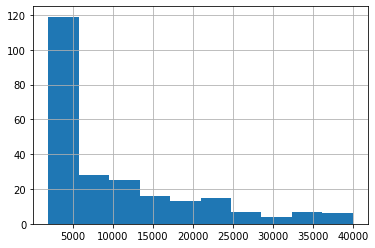

In [33]:
y.hist()

посмотрим количественные признаки:

<AxesSubplot:>

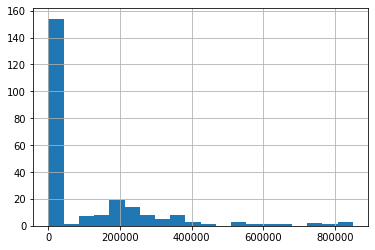

In [34]:
X["luminocity"].hist(bins = 20)

<AxesSubplot:>

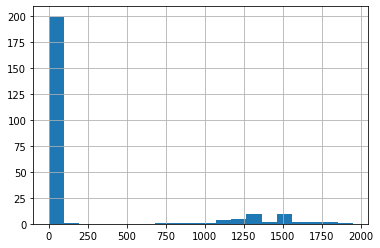

In [35]:
X["radius"].hist(bins = 20)

оба распределения по форме схожи с таргетом

<AxesSubplot:>

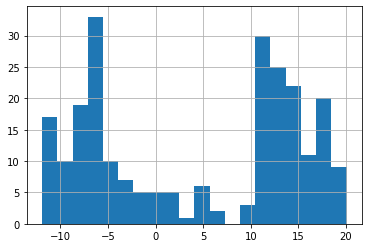

In [36]:
X["absolute_magnitude"].hist(bins = 20)

а здесь биноминальное распределение

посмотрим категориальные признаки

<AxesSubplot:xlabel='star_type', ylabel='count'>

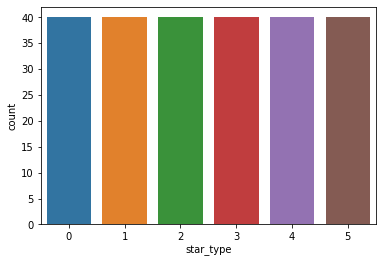

In [37]:
sns.countplot(x="random_sampler", data=X)

равномерное распределение

<AxesSubplot:xlabel='star_color', ylabel='count'>

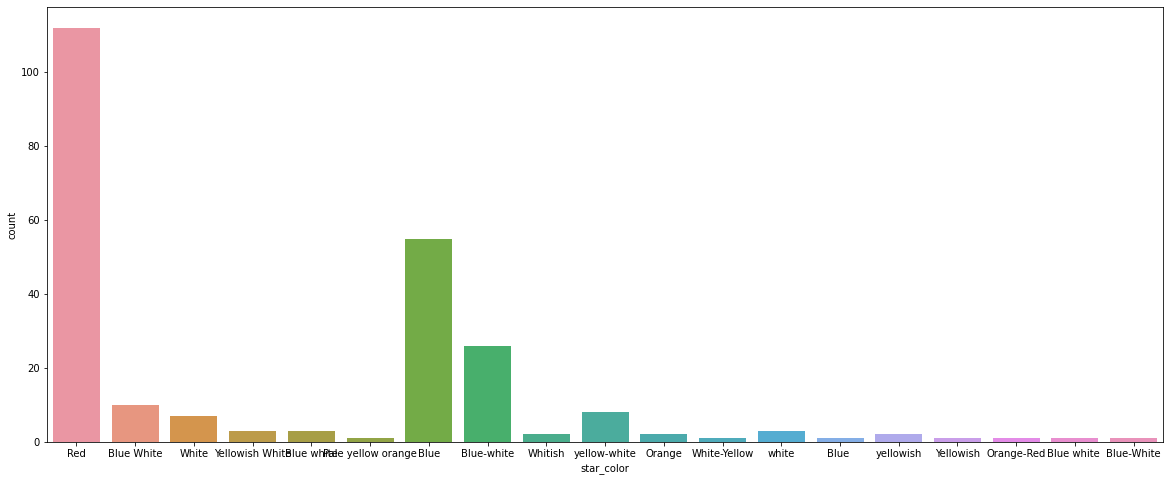

In [38]:
plt.figure(figsize=(20,8))
sns.countplot(x="star_color", data=X)

In [39]:
df["star_color"].value_counts(normalize=True)

Red                   0.466667
Blue                  0.229167
Blue-white            0.108333
Blue White            0.041667
yellow-white          0.033333
White                 0.029167
Blue white            0.012500
Yellowish White       0.012500
white                 0.012500
Whitish               0.008333
Orange                0.008333
yellowish             0.008333
Pale yellow orange    0.004167
White-Yellow          0.004167
Blue                  0.004167
Yellowish             0.004167
Orange-Red            0.004167
Blue white            0.004167
Blue-White            0.004167
Name: star_color, dtype: float64

много повторяющихся значений цветов. Сгруппируем их

In [40]:
def color_group(x):
    x = x.strip().lower()

    if x == "blue":
        return "blue"

    if x == "white" or x == "whitish":
        return "white"    

    if ("yellow" in x) and ("white" in x):
        return "blue_yellow"

    if ("blue" in x) and ("white" in x):
        return "blue_white"

    if x == "yellowish" or x == "pale yellow orange":
        return "yellow" 

    else: 
        return x    

X["star_color"] = df["star_color"].apply(color_group)

посмотрим, что получилось

In [ ]:
X["star_color"].value_counts(normalize=True)

red            0.466667
blue           0.233333
blue_white     0.170833
white          0.050000
blue_yellow    0.050000
yellow         0.016667
orange         0.008333
orange-red     0.004167
Name: star_color, dtype: float64

Установим постоянный рендом сид

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

разделим данные на трейн и тест

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

выделим категориальные и кол-венные признаки

In [ ]:
num_cols = ["luminocity", "radius", "absolute_magnitude"]
cat_cols = ["star_type", "star_color"]

сделаем енкодинг категориальных и кол-ных признаков

In [ ]:
cat_transformer_linear = OneHotEncoder(handle_unknown='ignore')
num_transformer_linear = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer_linear, num_cols),
        ("cat", cat_transformer_linear, cat_cols)
    ]
)

In [ ]:
X_train_prep = preprocessor.fit_transform(X_tr)
X_valid_prep = preprocessor.transform(X_val)

подготовим данные к обучению

In [ ]:
features_count = X_train_prep.shape[1]

X_train = torch.from_numpy(X_train_prep).float()
X_valid = torch.from_numpy(X_valid_prep).float()
y_train = torch.FloatTensor(y_tr.to_numpy())
y_valid = torch.FloatTensor(y_val.to_numpy())

train_data = TensorDataset(X_train, y_train)

## Обучим модель baseline

сделаем сетку для параметров baseline. Установим кол-во скрытых слоев равное 2. Возьмем 40 случайных вариантов

In [52]:
rng = np.random.RandomState(0)

baseline_grid = {
                 "n_neurons_in": [features_count],
                 "n_neurons_out": [1],
                 "n_hidden_1":[40, 30, 20, 15],
                 "n_hidden_2":[12, 10, 8, 6],
                 "activation_1": [nn.ReLU(), None],
                 "activation_2": [nn.ReLU(), None],
                 "activation_out": [nn.ReLU(), None]
                }
                
baseline_list = list(ParameterSampler(baseline_grid, n_iter=40,
                                   random_state=rng))

сделаем функцию для инициализации весов. Такой диапaзон для несимметричных функций, как ReLU, вроде способен сохранить дисперсию весов при прямом распространении

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, mean=0, std=np.sqrt(2/layer.in_features))
        nn.init.normal_(layer.bias, mean=0, std=0)

напишем цикл для обучения и нахождения лучших гиперпараметров baseline модели. Будем сохранять лучшей показатель rmse для каждого параметра в словарь. А лучшую среди всех моделей сохраним в файл

In [ ]:
num_epochs = 1500
results_baseline = {}
best_score_overall = 10e+10000

for i, param in enumerate(baseline_list):

	best_score_current_param = 1e+100000
	net_layers = []

	net_layers.append(nn.Linear(param["n_neurons_in"], param["n_hidden_1"]))
	
	if param["activation_1"] is not None:
		net_layers.append(param["activation_1"])
	
	net_layers.append(nn.Linear(param["n_hidden_1"], param["n_hidden_2"]))

	if param["activation_2"] is not None:
		net_layers.append(param["activation_2"])

	net_layers.append(nn.Linear(param["n_hidden_2"], param["n_neurons_out"]))
	
	if param["activation_out"] is not None:
		net_layers.append(param["activation_out"])

	net = nn.Sequential(*net_layers) 
	net.apply(init_weights)
	optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
	loss = nn.MSELoss()
	

	for epoch in range(num_epochs):

		preds = net.forward(X_train)      
		loss_value = loss(preds.reshape(-1,), y_train)

		
		optimizer.zero_grad()
		loss_value.backward()        
		optimizer.step()

		if epoch % 5 == 0 or epoch == num_epochs - 1:
			net.eval()
			valid_preds = net.forward(X_valid)
			rmse_valid = round(np.sqrt(mean_squared_error(y_valid, valid_preds.detach().numpy())))

			is_best_overall = rmse_valid < best_score_overall
			best_score_overall = min(rmse_valid, best_score_overall)

			is_best_current_param = rmse_valid < best_score_current_param
			best_score_current_param = min(rmse_valid, best_score_current_param)

			if is_best_overall:
				torch.save(net, "best_model.pth")

			if is_best_current_param:
				results_baseline[i] = (param, best_score_current_param)

посмотрим результаты

In [ ]:
results_baseline_df = pd.DataFrame.from_dict(results_baseline, orient='index')
unpack_params = results_baseline_df[0].apply(pd.Series).drop(columns={"n_neurons_out", "n_neurons_in"}, axis=1)
unpack_params["score"] = results_baseline_df[1]
results_baseline_df = unpack_params.sort_values(by="score")
results_baseline_df.head()

,n_hidden_2,n_hidden_1,activation_out,activation_2,activation_1,score
32,12.0,15.0,ReLU(),ReLU(),None,4821
8,10.0,20.0,ReLU(),ReLU(),None,4826
13,8.0,15.0,None,ReLU(),None,4925
12,10.0,20.0,None,ReLU(),None,4933
23,12.0,30.0,ReLU(),ReLU(),None,4936


посмотрим, сохранили ли мы в файл наилучшую модель

In [ ]:
model = torch.load("best_model.pth")
model.eval()
preds = model.forward(X_valid)

rmse_valid = round(np.sqrt(mean_squared_error(y_valid, preds.detach().numpy())))
rmse_valid

4821

In [ ]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=16, out_features=15, bias=True)
  (1): Linear(in_features=15, out_features=12, bias=True)
  (2): ReLU()
  (3): Linear(in_features=12, out_features=1, bias=True)
  (4): ReLU()
)>

все верно. Теперь построим график сравнения реальной температуры и предсказанной для каждой звезды

## График сравнения реальных температур и прогноза

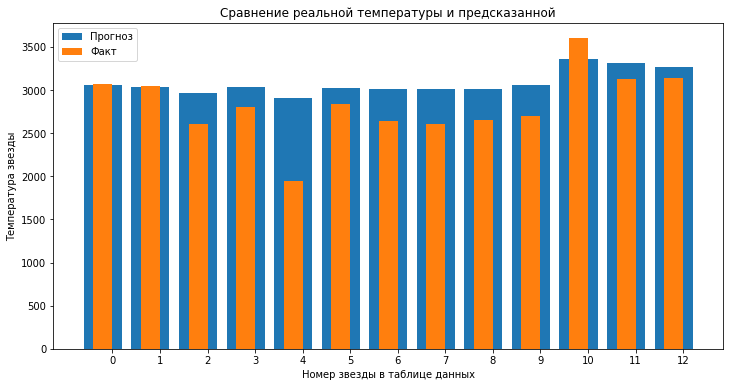

In [ ]:
X_prep = preprocessor.transform(X)
X_prep_tensor = torch.from_numpy(X_prep).float()
prep = model.forward(X_prep_tensor)
X["preds"] = prep.detach().numpy()
X["id"] = X.index
X["temperature"] = y
X_first_13 = X[0:13]

X_axis = np.arange(len(X_first_13))
plt.figure(figsize=(12,6))
plt.bar(X_axis - 0.2, X_first_13["preds"], 0.8, label="Прогноз")
plt.bar(X_axis - 0.2, X_first_13["temperature"], 0.4, label="Факт")
plt.xticks(X_axis, X_first_13["id"])
plt.xlabel("Номер звезды в таблице данных")
plt.ylabel("Температура звезды")
plt.legend(loc='upper left')
plt.title("Сравнение реальной температуры и предсказанной")
plt.show()

In [ ]:
X["temperature"]

0       3068
1       3042
2       2600
3       2800
4       1939
       ...  
235    38940
236    30839
237     8829
238     9235
239    37882
Name: temperature, Length: 240, dtype: int64

## Улучшение полученной модели

Сделаем сетку для тюнинга получившейся модели. По исследованием использование одновременно batchNorm и dropout не приводит к хорошим результатов. Так что, будем использовать или одно, или другое. Возьмем 20 слуйных параметров

In [55]:
tuning_grid = {
                "regularization": ["batch_norm", "dropout"],
                "batch_size": [192, 128, 64],
                "learning_rate": [0.05, 0.03, 0.01, 0.007],
                }
                
tuning_list = list(ParameterSampler(tuning_grid, n_iter=20,
                                   random_state=rng))

Возьмем параметры лучшей модели из baseline

In [ ]:
best_model_params = np.array(results_baseline_df.head(1))
results_baseline_df.head(1)

,n_hidden_2,n_hidden_1,activation_out,activation_2,activation_1,score
32,12.0,15.0,ReLU(),ReLU(),None,4821


In [ ]:
n_hidden_1 = int(best_model_params[0,1])
n_hidden_2 = int(best_model_params[0,0])
activation_1 = best_model_params[0,4]
activation_2 = best_model_params[0,3]
activation_out = best_model_params[0,2]

напишем цикл, похожий на предыдущий, только добавим обучение по батчам.

In [ ]:
num_epochs = 1000
results_tuning = {}
is_best_overall = False
best_score_overall = 10e+10000

for i, param in enumerate(tuning_list):
	
	best_score_current_param = 10e+10000
	net_layers = []
	
	net_layers.append(nn.Linear(features_count, n_hidden_1))
	
	if param["regularization"] == "dropout":
		net_layers.append(nn.Dropout(p=0.5))
	elif param["regularization"] == "batch_norm":
		net_layers.append(nn.BatchNorm1d(n_hidden_1))	

	if activation_1:
		net_layers.append(activation_1)

	net_layers.append(nn.Linear(n_hidden_1, n_hidden_2))

	if param["regularization"] == "dropout":
		net_layers.append(nn.Dropout(p=0.5))
	elif param["regularization"] == "batch_norm":
		net_layers.append(nn.BatchNorm1d(n_hidden_2))

	if activation_2:
		net_layers.append(activation_2)	

	net_layers.append(nn.Linear(n_hidden_2, 1))
	
	if activation_out:
		net_layers.append(activation_out)

	net = nn.Sequential(*net_layers) 
	net.apply(init_weights)
	optimizer = torch.optim.Adam(net.parameters(), param["learning_rate"])
	loss = nn.MSELoss()

	train_data = TensorDataset(X_train, y_train)
	train_loader = DataLoader(dataset=train_data, batch_size=param["batch_size"], shuffle=True)

	for _ in range(num_epochs):
		for i_batch, batch in enumerate(train_loader):

			X_batch, y_batch = batch
			preds = net.forward(X_batch)      
			loss_value = loss(preds.reshape(-1,), y_batch)

			optimizer.zero_grad()
			loss_value.backward()        
			optimizer.step()

			if i_batch % 2 == 0 or i_batch == i_batch - 1:
				net.eval()
				valid_preds = net.forward(X_valid)

				rmse_train = round(np.sqrt(loss_value.item()))
				rmse_valid = round(np.sqrt(mean_squared_error(y_valid, valid_preds.detach().numpy())))
				
				is_best_overall = rmse_valid < best_score_overall
				best_score_overall = min(rmse_valid, best_score_overall)

				is_best_current_param = rmse_valid < best_score_current_param
				best_score_current_param = min(rmse_valid, best_score_current_param)

				if is_best_overall:
					torch.save(net, "best_model_tuning.pth")

				if is_best_current_param:
					results_tuning[i] = (param, best_score_current_param)		

посмотрим результаты

In [ ]:
results_tuning_df = pd.DataFrame.from_dict(results_tuning, orient='index')
unpack_params = results_tuning_df[0].apply(pd.Series)
unpack_params["score"] = results_tuning_df[1]
results_tuning_df = unpack_params.sort_values(by="score")
results_tuning_df.head()

,regularization,learning_rate,batch_size,score
0,batch_norm,0.050,128,4196
17,batch_norm,0.007,128,4810
12,dropout,0.030,128,4838
10,batch_norm,0.030,128,4838
5,batch_norm,0.050,64,4849


загрузим модель и сверим с лучшим значением

In [ ]:
model = torch.load("best_model_tuning.pth")
model.eval()
preds = model.forward(X_valid)

rmse_valid = round(np.sqrt(mean_squared_error(y_valid, preds.detach().numpy())))
rmse_valid

4196

rmse чуть лучше, чем нужно было в цели задания

## Вывод

Мы провели исследование данных, выполнили предобработку и сгруппировали признаки. Построили базовую модель и получили на ней результат rmse=4821. Добавив обучение по батчам и регулиризацию, мы смогли довести метрику до значения 4196. Параметры полученной модели:

In [ ]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=16, out_features=15, bias=True)
  (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=15, out_features=12, bias=True)
  (3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Linear(in_features=12, out_features=1, bias=True)
  (6): ReLU()
)>